# Research Question No. 3

## How frequent are, and what are the main characteristics of long-lived bugs?

## Step1. Setup environment.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:

import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string
import re

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import FuncFormatter

# Setup Seaborn
sns.set_context("paper")
sns.set(style="ticks", color_codes=True, font_scale=2)

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 



# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
projects = ['eclipse', 'freedesktop', 'gnome', 'mozilla', 'gcc', 'winehq']

# Fixed time threshold.
bug_reports_file_prefix  = '20200731'
bug_fix_time_threshold   = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Common Functions

In [3]:
def plot_pyramid (data, column, sort_column, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values(sort_column, ascending=True)
    
    print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True

    sns.despine(offset=0.5)
    sns.barplot(x="long-lived", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="short-lived", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE)
    axes[0].set_xlabel("long-lived", fontsize=MEDIUM_SIZE)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[1].set_xlabel("short-lived", fontsize=MEDIUM_SIZE)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    #fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


## Step 2. Load data.

In [3]:
bug_reports_path = f"datasets/{bug_reports_file_prefix}_bug_reports_all_data.csv"
if (os.path.exists(bug_reports_path)):
    print(f"{bug_reports_path} exists, read data from it!")
    bug_reports_all_data = pd.read_csv(bug_reports_path)
else:
    print(f"{bug_reports_path} don't exists, stop processing!")
    


datasets/20200731_bug_reports_all_data.csv exists, read data from it!


## Step 3. Review the data

In [4]:
bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_lived?
0,RECOMMENDERS-467951,2015-05-22,Core,RECOMMENDERS,LogTraceException in ProposalUtils.toMethodNam...,The following incident was reported via the au...,recommenders-inbox,error-reports-inbox,fixed,1,...,2015-05-27,0,2,2015-05-27,5,normal,2,eclipse,3,short-lived
1,QVTO-463396,2015-03-29,Engine,QVTO,CCE in DecorationNodeImpl.eSet (159),The following incident was reported via the au...,serg.boyko2011,error-reports-inbox,fixed,1,...,2015-04-01,0,8,2015-03-31,2,normal,2,eclipse,3,short-lived
2,EQUINOX-530069,2018-01-20,Compendium,EQUINOX,[http servlet] During dispatching javax.servle...,Original issue https://issues.liferay.com/brow...,raymond.auge,raymond.auge,fixed,1,...,2018-01-22,0,3,2018-01-22,2,normal,2,eclipse,10,short-lived
3,NATTABLE-422482,2013-11-25,Core,NATTABLE,Left border of NatTable is not drawn,Rendering a NatTable on a Composite with margi...,dirk.fauth,dirk.fauth,fixed,1,...,2014-07-23,0,3,2013-11-25,0,normal,2,eclipse,4,short-lived
4,WTP_JAVA_EE_TOOLS-116294,2005-11-14,jst.j2ee,WTP_JAVA_EE_TOOLS,NPE while importing EAR with utility jar,Import and EAR which has EJb and Ejb client tr...,jsholl,nagrawal,fixed,1,...,2005-12-09,0,4,2005-11-15,1,blocker,6,eclipse,5,short-lived


In [5]:
bug_reports_all_data.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code,short_description_words
count,51068.0,51068.000000,51068.000000,51068.000000,51068.000000,51068.000000,51068.000000
mean,1.0,4.411256,0.079815,8.701849,233.191353,2.356838,5.905792
std,0.0,0.808327,1.312334,12.315590,525.378616,0.988412,2.346749
min,1.0,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.0,4.000000,0.000000,3.000000,3.000000,2.000000,4.000000
50%,1.0,4.000000,0.000000,6.000000,26.000000,2.000000,6.000000
75%,1.0,4.000000,0.000000,10.000000,193.000000,2.000000,7.000000
max,1.0,6.000000,101.000000,810.000000,7294.000000,6.000000,27.000000


In [6]:
bug_reports_all_data.loc[bug_reports_all_data['bug_fix_time'] < 0]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_lived?


## Step 4. Pre-processing the data

In [7]:
bug_reports_all_data['project'].value_counts()

gcc            9946
mozilla        9945
eclipse        9724
gnome          7772
freedesktop    7644
winehq         6037
Name: project, dtype: int64

## Step 6. Bug Reporter

In [31]:
def plot_abc(project, column, n=None):
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    """
    plots a pareto chart.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    performance = data['acumulado'].tolist()
    y_pos = np.arange(len(performance))
    y_pos = (y_pos / max(y_pos))
    
    # Change major ticks to show every 500.
    ax.xaxis.set_major_locator(MultipleLocator(0.20))
    ax.yaxis.set_major_locator(MultipleLocator(0.20))

    # Change minor ticks to show every 5. (20/4 = 5)
  
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    #plt.title(f"Project: {project.capitalize()}")
    plt.grid(True)
    plt.plot(y_pos, performance, color='tab:blue')
    plt.ylabel('% of bug reports')
    plt.ylim(0, 1)
    plt.xlabel("% of {}".format(column.replace("_name", "")+"s"))
    plt.xlim(0, 1)
 
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
 
    index = np.argmin(np.abs(np.array(y_pos)-0.2))
    plt.axvline(x=.2, color='gray',linestyle='--')
    plt.axhline(y=performance[index],color='gray',linestyle='--')

    plt.scatter(.2, performance[index], color='tab:blue' )
    plt.savefig(f"figures/rq3-percentage-of-bugs-by-{column}_{project}.pdf", format="pdf", dpi=600, bbox_inches='tight')

    
def plot_pareto(project, column, n=10):
    """
    plots a pareto chart.
    
    """
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    
    fig, axes = plt.subplots(figsize=(10,5))
    ax1 = data.head(n).plot(use_index=True, y='count',  kind='bar', ax=axes)
    ax2 = data.head(n).plot(use_index=True, y='acumulado', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)

    ax1.set(title=project.capitalize(), ylabel="Bugs Reports")
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend().set_visible(False)
    
    ax2.set(ylim=(0, 1.1), ylabel="Cumulative Percentage")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

def plot_pareto_modificado(project, column, n=10):
    """
    plots a pareto chart modificado.
    
    """
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    data['acumulado_label'] = data['acumulado'] * 100
    data.set_index('acumulado_label', inplace=True)
    fig, axes = plt.subplots(figsize=(20,10))
    
    ax1 = data.plot(use_index=True, y='count',  kind='bar', ax=axes)
    ax2 = data.plot(use_index=True, y='acumulado', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
    
    ax1.set(title=project.capitalize(), ylabel="Bugs Reports")
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend().set_visible(False)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    
    ax2.set(ylim=(0, 1.1), ylabel="Cumulative Percentage")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    
    
def plot_bar (project, column, ax):
    from matplotlib.ticker import FuncFormatter
    top_10 = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    top_10 = top_10.groupby(column)[column].agg(['count'])
    top_10 = top_10.sort_values('count', ascending=False).head(10)
    
    bug_reports_data_for_top_10=bug_reports_all_data[bug_reports_all_data[column].isin(top_10.index)]
    top_10_grouped = bug_reports_data_for_top_10.groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_10_grouped.plot(kind='bar', stacked='True', color=["tab:red", "tab:blue"], ax=ax)
    ax.legend()
    ax.set(ylim=(0, 1))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))    
    ax.set(title=project.capitalize(), xlabel="", ylabel="")
    

def plot_s_bar (bugs, column, n, filename):
    from matplotlib.ticker import FuncFormatter
    top_n_df = pd.DataFrame(columns=['Project', 'Label', 'Value']) 
    
    for project in projects:
        data   = bugs.loc[bugs['project']==project]
        top_g  = data.groupby(column)[column].agg(['count'])
        top_s  = top_g.sort_values('count', ascending=False).head(n)
        value    = top_s['count'].sum() / data.shape[0]
        
        top_n_df = top_n_df.append({'Project': project.capitalize(), 'Label': 'others',   'Value': 1 - value}, ignore_index=True)
        top_n_df = top_n_df.append({'Project': project.capitalize(), 'Label': f"top {n}", 'Value': value}, ignore_index=True)
    
    
    top_n_df_pivot = top_n_df.pivot(index='Project', columns='Label', values='Value')
    ax = top_n_df_pivot.plot.bar(stacked=True, color=["tab:green", "tab:orange"], figsize=(10,7))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
 
    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = False
    ax.yaxis.grid(linestyle=':')
    
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel("", fontsize=MEDIUM_SIZE)
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))    
    ax.set(ylim=(0, 1))
 
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, ncol=5)

    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')
    
def plot_topn_pie (project, data, column, n, filename):
    
    data   = data.loc[data['project']==project]
    top_g  = data.groupby(column)[column].agg(['count'])
    top_s  = top_g.sort_values('count', ascending=False).head(n)
    
    labels    = [f"Top {n}"]
    top_n     = top_s.reset_index()
    values    = [top_s['count'].sum()] 
    labels.append('Others')
    values.append(data.shape[0] - sum(values))
    
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
    ax1.pie(values, labels=labels
            , autopct='%1.1f%%'
            , colors=["tab:green", "tab:orange"]
            , textprops={'fontsize': SMALL_SIZE-1})
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


def plot_top_n_pie(column, n=10):
    
    def plot_pie(v, l, color=None):
        plt.pie(v
                , labels=l.values
                , autopct='%1.1f%%'
                , colors=["tab:green", "tab:orange"]
                , textprops={'fontsize': MEDIUM_SIZE-4})
        plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')
    

    top_10_summary = pd.DataFrame(columns=['project', 'count', 'pct', 'category'])
                                       
    for i in range(6):
        project = projects[i]
        all_bugs = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
        top_10 = all_bugs.groupby(column)[column].agg(['count'])
        top_10 = top_10.sort_values('count', ascending=False).head(n)
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , top_10['count'].sum()
                                                         , top_10['count'].sum()/all_bugs['bug_id'].count()
                                                         , f"Top {n}")
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , all_bugs['bug_id'].count()-top_10['count'].sum()
                                                         , (all_bugs['bug_id'].count()-top_10['count'].sum())/all_bugs['bug_id'].count()
                                                         , 'Others')

    projects_ordered = top_10_summary.loc[top_10_summary.category==f"Top {n}"].sort_values('project')['project']

    #plot pie charts
    #sns.set(style="ticks", color_codes=True, font_scale=2.0)
        
    g = sns.FacetGrid(top_10_summary, col="project", col_wrap=3, height=8
                  , col_order=projects_ordered
                  , aspect=1.5)
    g = g.map(plot_pie, "count", "category")
    g.set(ylabel="", xlabel="")
    g.set_titles("{col_name}", fontsize=MEDIUM_SIZE)

def plot_pyramid (data, column, sort_column, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values(sort_column, ascending=True)
    
    print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True

    sns.despine(offset=0.5)
    sns.barplot(x="long-lived", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="short-lived", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE)
    axes[0].set_xlabel("long-lived", fontsize=MEDIUM_SIZE)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[1].set_xlabel("short-lived", fontsize=MEDIUM_SIZE)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    #fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


In [28]:
# -------------------------------------- DEBUG ------------------------------------------
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
total = len(data)
count = len(data['reporter_name'].value_counts())
percentage = int(count * 0.2)
percentage_in_20_perc = (sum(data['reporter_name'].value_counts()[0:percentage])) / total
display(percentage_in_20_perc)
# ------------------------------------- DEBUG ------------------------------------------

0.6360775219479874

<Figure size 432x288 with 0 Axes>

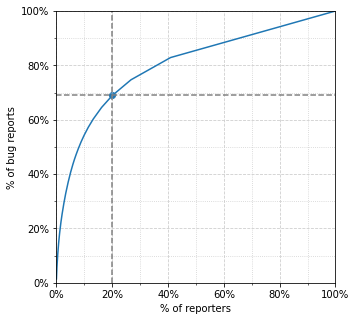

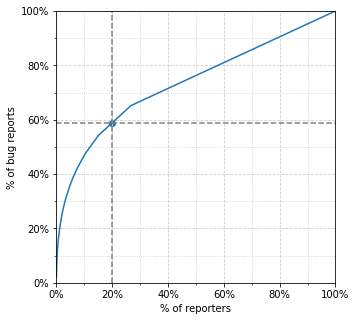

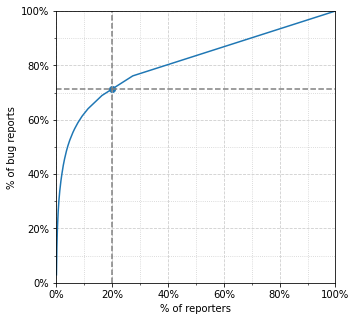

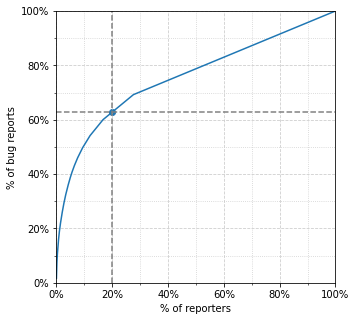

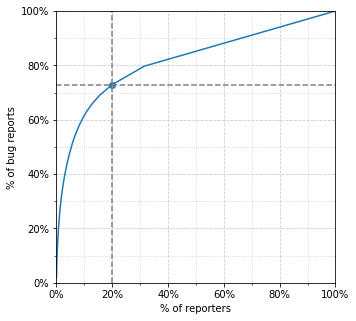

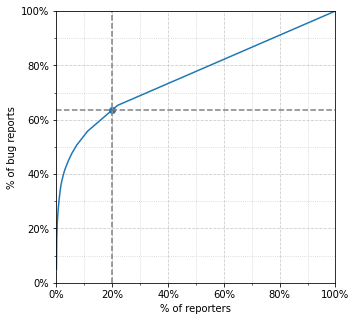

In [10]:
# abc plot.
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'freedesktop', 'gcc', 'gnome', 'mozilla', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'reporter_name', 100)

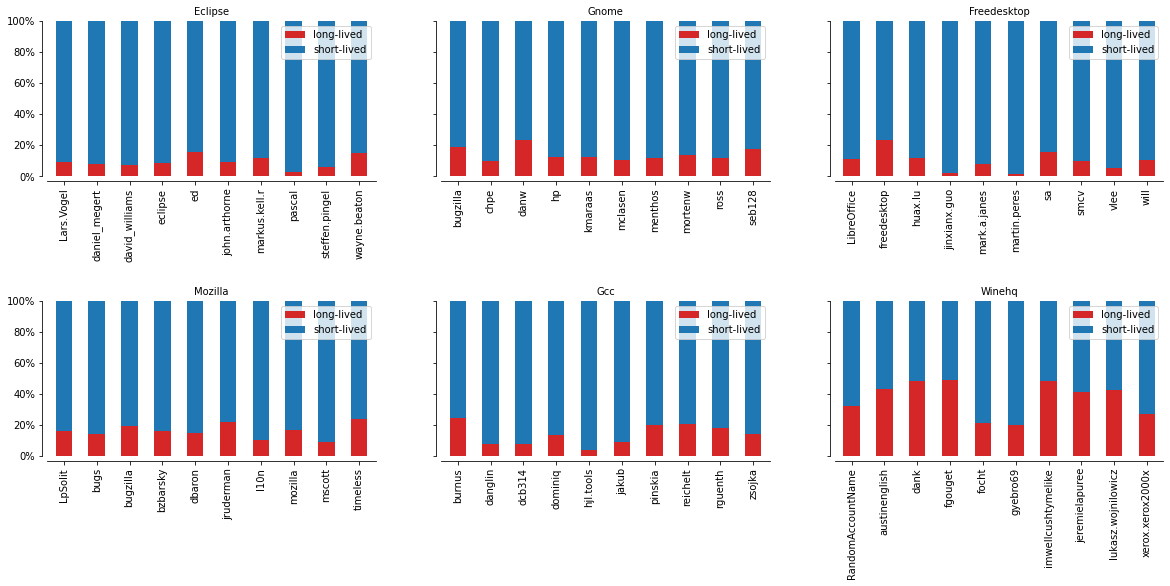

In [11]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'reporter_name', ax)

plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-bug-reporter.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 7. Assignee

In [12]:
# -------------------------------------- DEBUG ------------------------------------------
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
total = len(data)
count = len(data['assignee_name'].value_counts())
percentage = int(count * 0.2)
percentage_in_20_perc = (sum(data['assignee_name'].value_counts()[0:percentage])) / total
display(percentage_in_20_perc)
# ------------------------------------- DEBUG ------------------------------------------

0.9749875766108994

<Figure size 432x288 with 0 Axes>

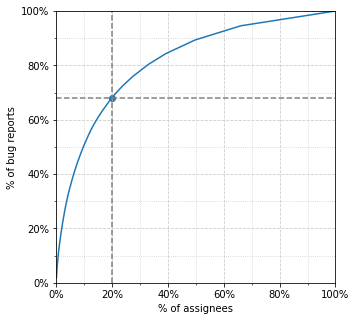

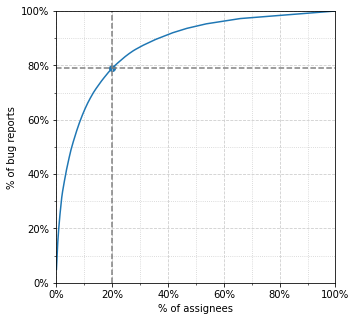

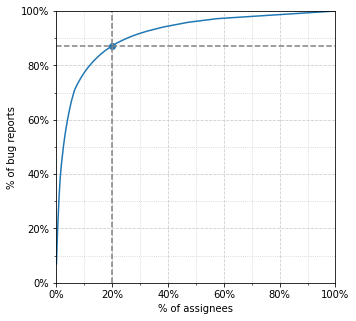

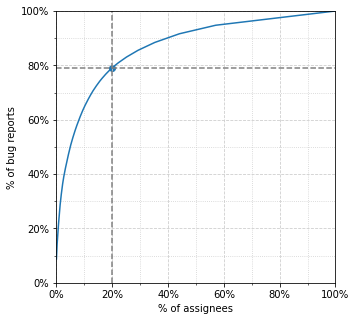

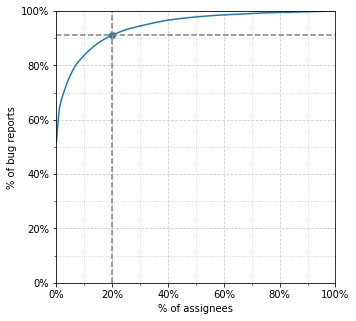

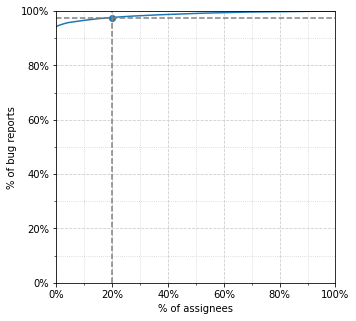

In [13]:
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'assignee_name', 100)


## 7.1 Short-lived vs. Long-lived by Top 10 Assignee

In [14]:
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
(data['assignee_name'].value_counts()/data['assignee_name'].value_counts().sum()).head(10)

wine-bugs          0.943515
jnewman            0.005301
mike               0.004141
us                 0.003810
truiken            0.002153
eric.pouech        0.001988
00cpxxx            0.001822
dpaun              0.001822
stefandoesinger    0.001822
apa3a              0.001656
Name: assignee_name, dtype: float64

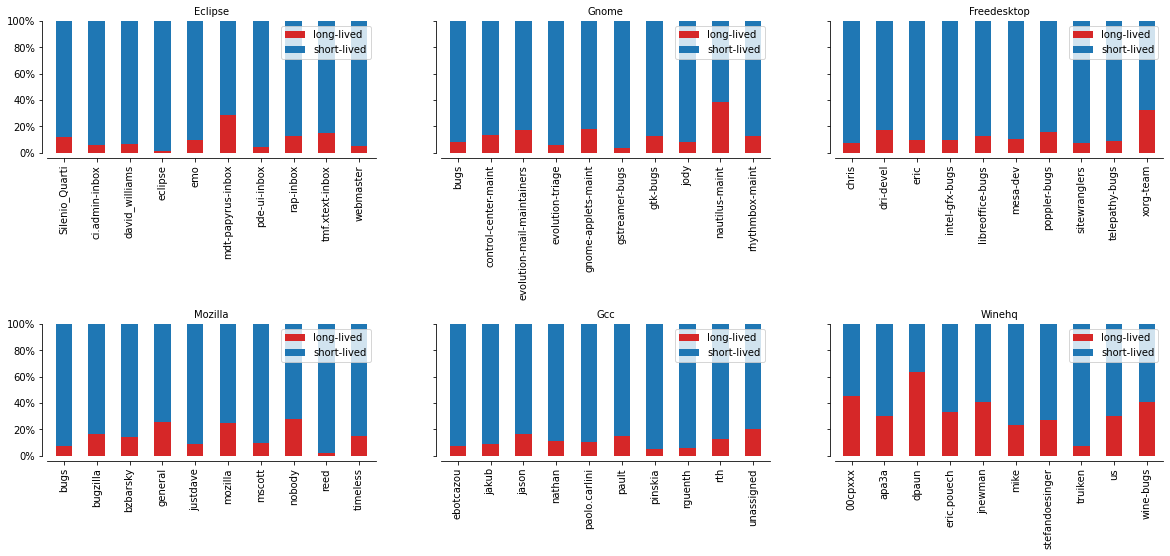

In [15]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=1.3)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'assignee_name', ax)

plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-assignee.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 8. Component

<Figure size 432x288 with 0 Axes>

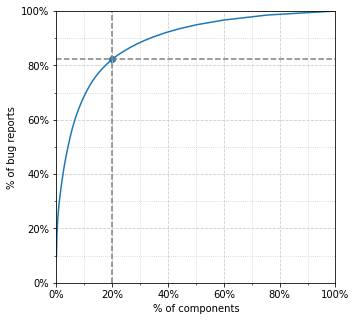

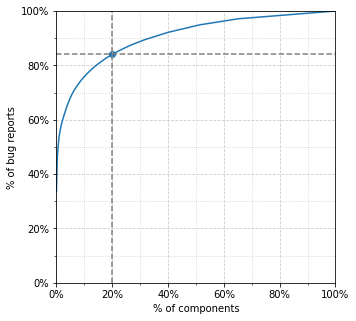

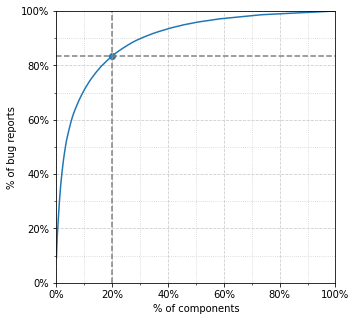

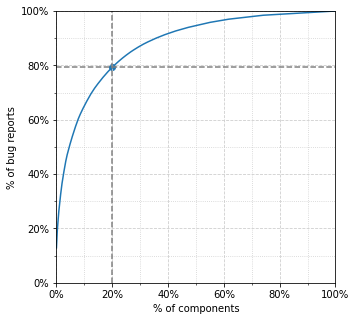

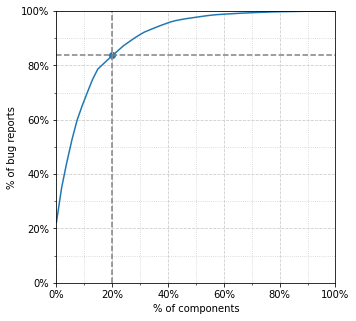

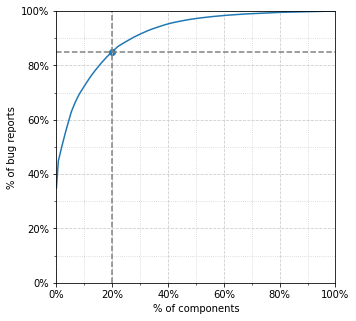

In [16]:
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'component_name', 100)

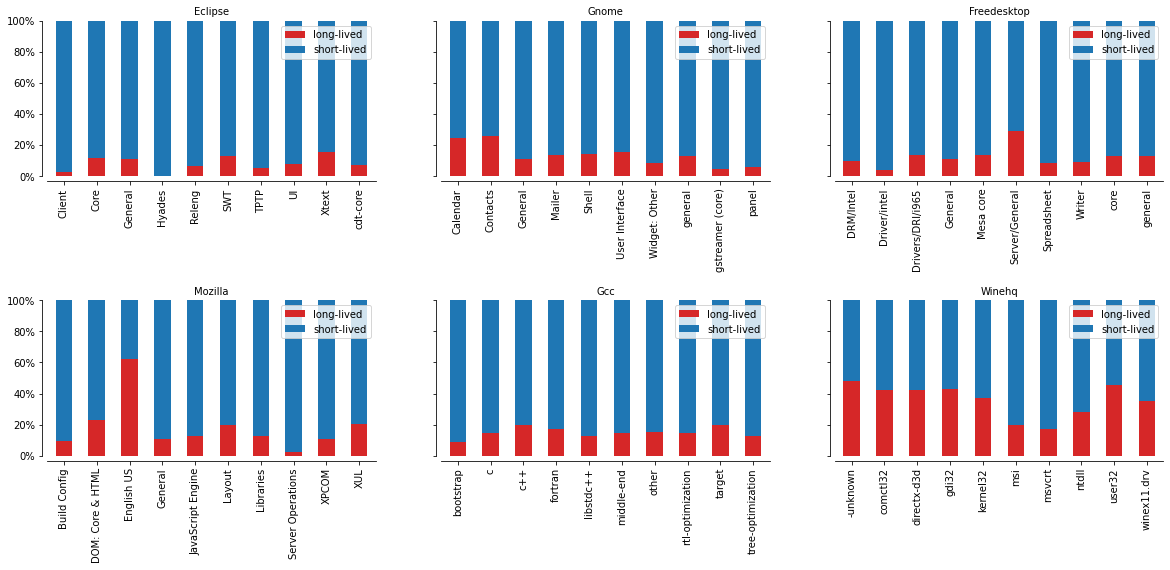

In [17]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'component_name', ax)
    
plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-component.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 9. Analysis of Short and Long Descrption

### 9.1 - Short Description Word cloud

In [18]:
from PIL import Image
import matplotlib

def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=0
                      , normalize_plurals=False).generate(text)
    else:
        sl_wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=0
                      , normalize_plurals=False
                      , stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title, fontsize=20)
    axe.axis("off")



def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['wine', 'dll', 'window', 'project'
                           , 'view', 'editor', 'file', 'test'
                           , 'update', 'will', 'crashes', 'crash', 'gcc'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, '{}: Short-Lived Bugs'.format(title), ax[0])
    plot_one_word_cloud(ll_text, '{}: Long-Lived Bugs'.format(title), ax[1])


TypeError: sequence item 16267: expected str instance, float found

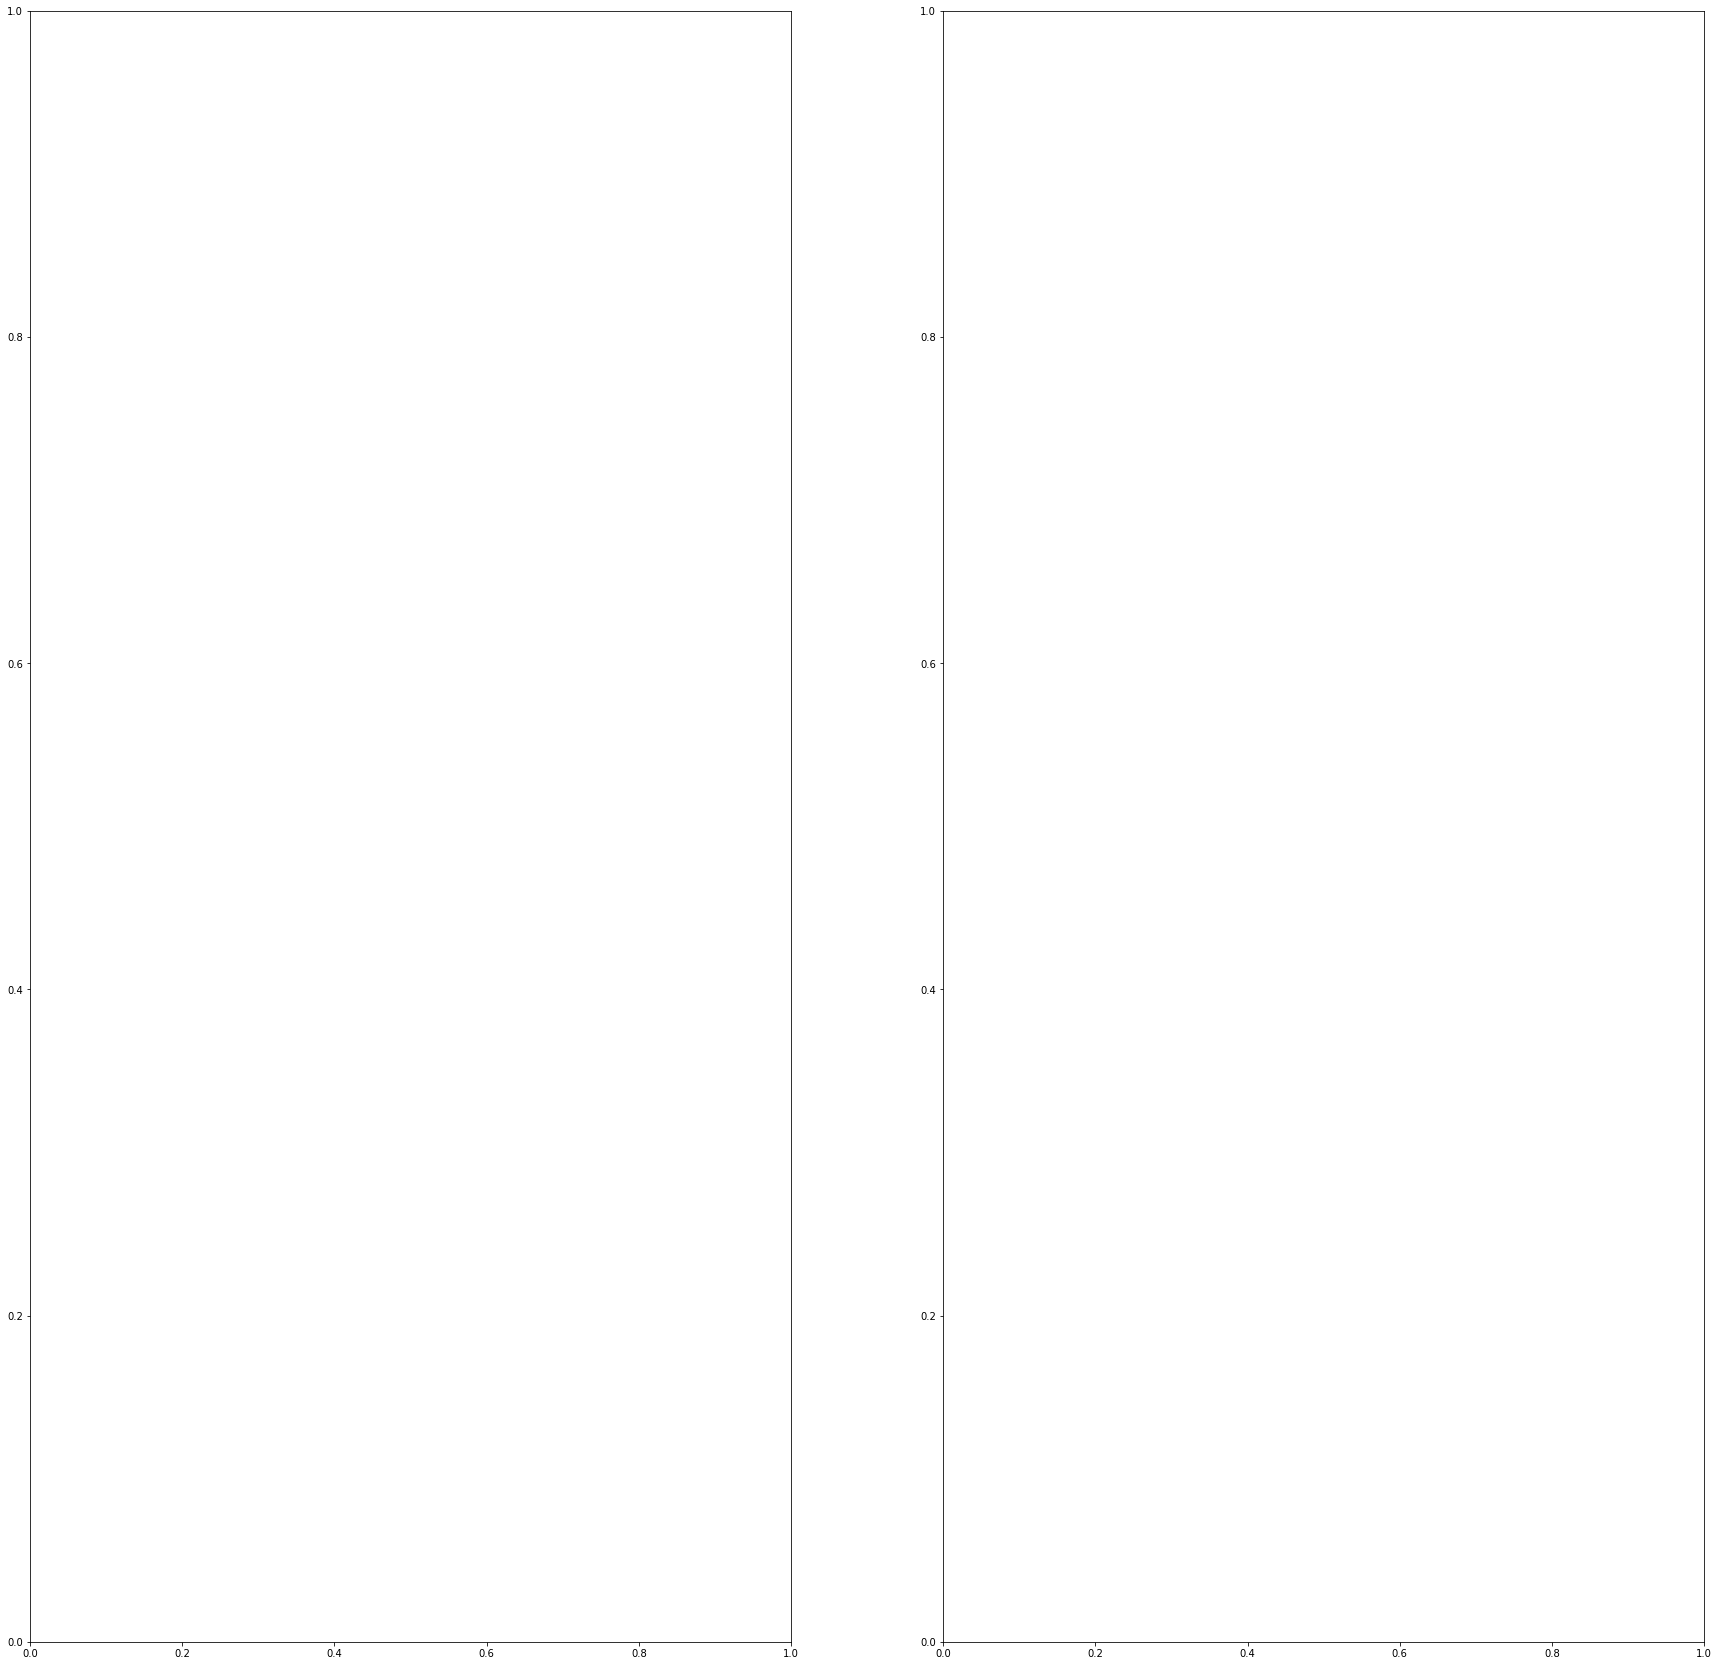

In [19]:
#plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].short_description, bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].short_description, 'Summary')
#plt.savefig(f"figures/rq3-all-short_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


### 9.2 - Long Description Word cloud

TypeError: sequence item 71: expected str instance, float found

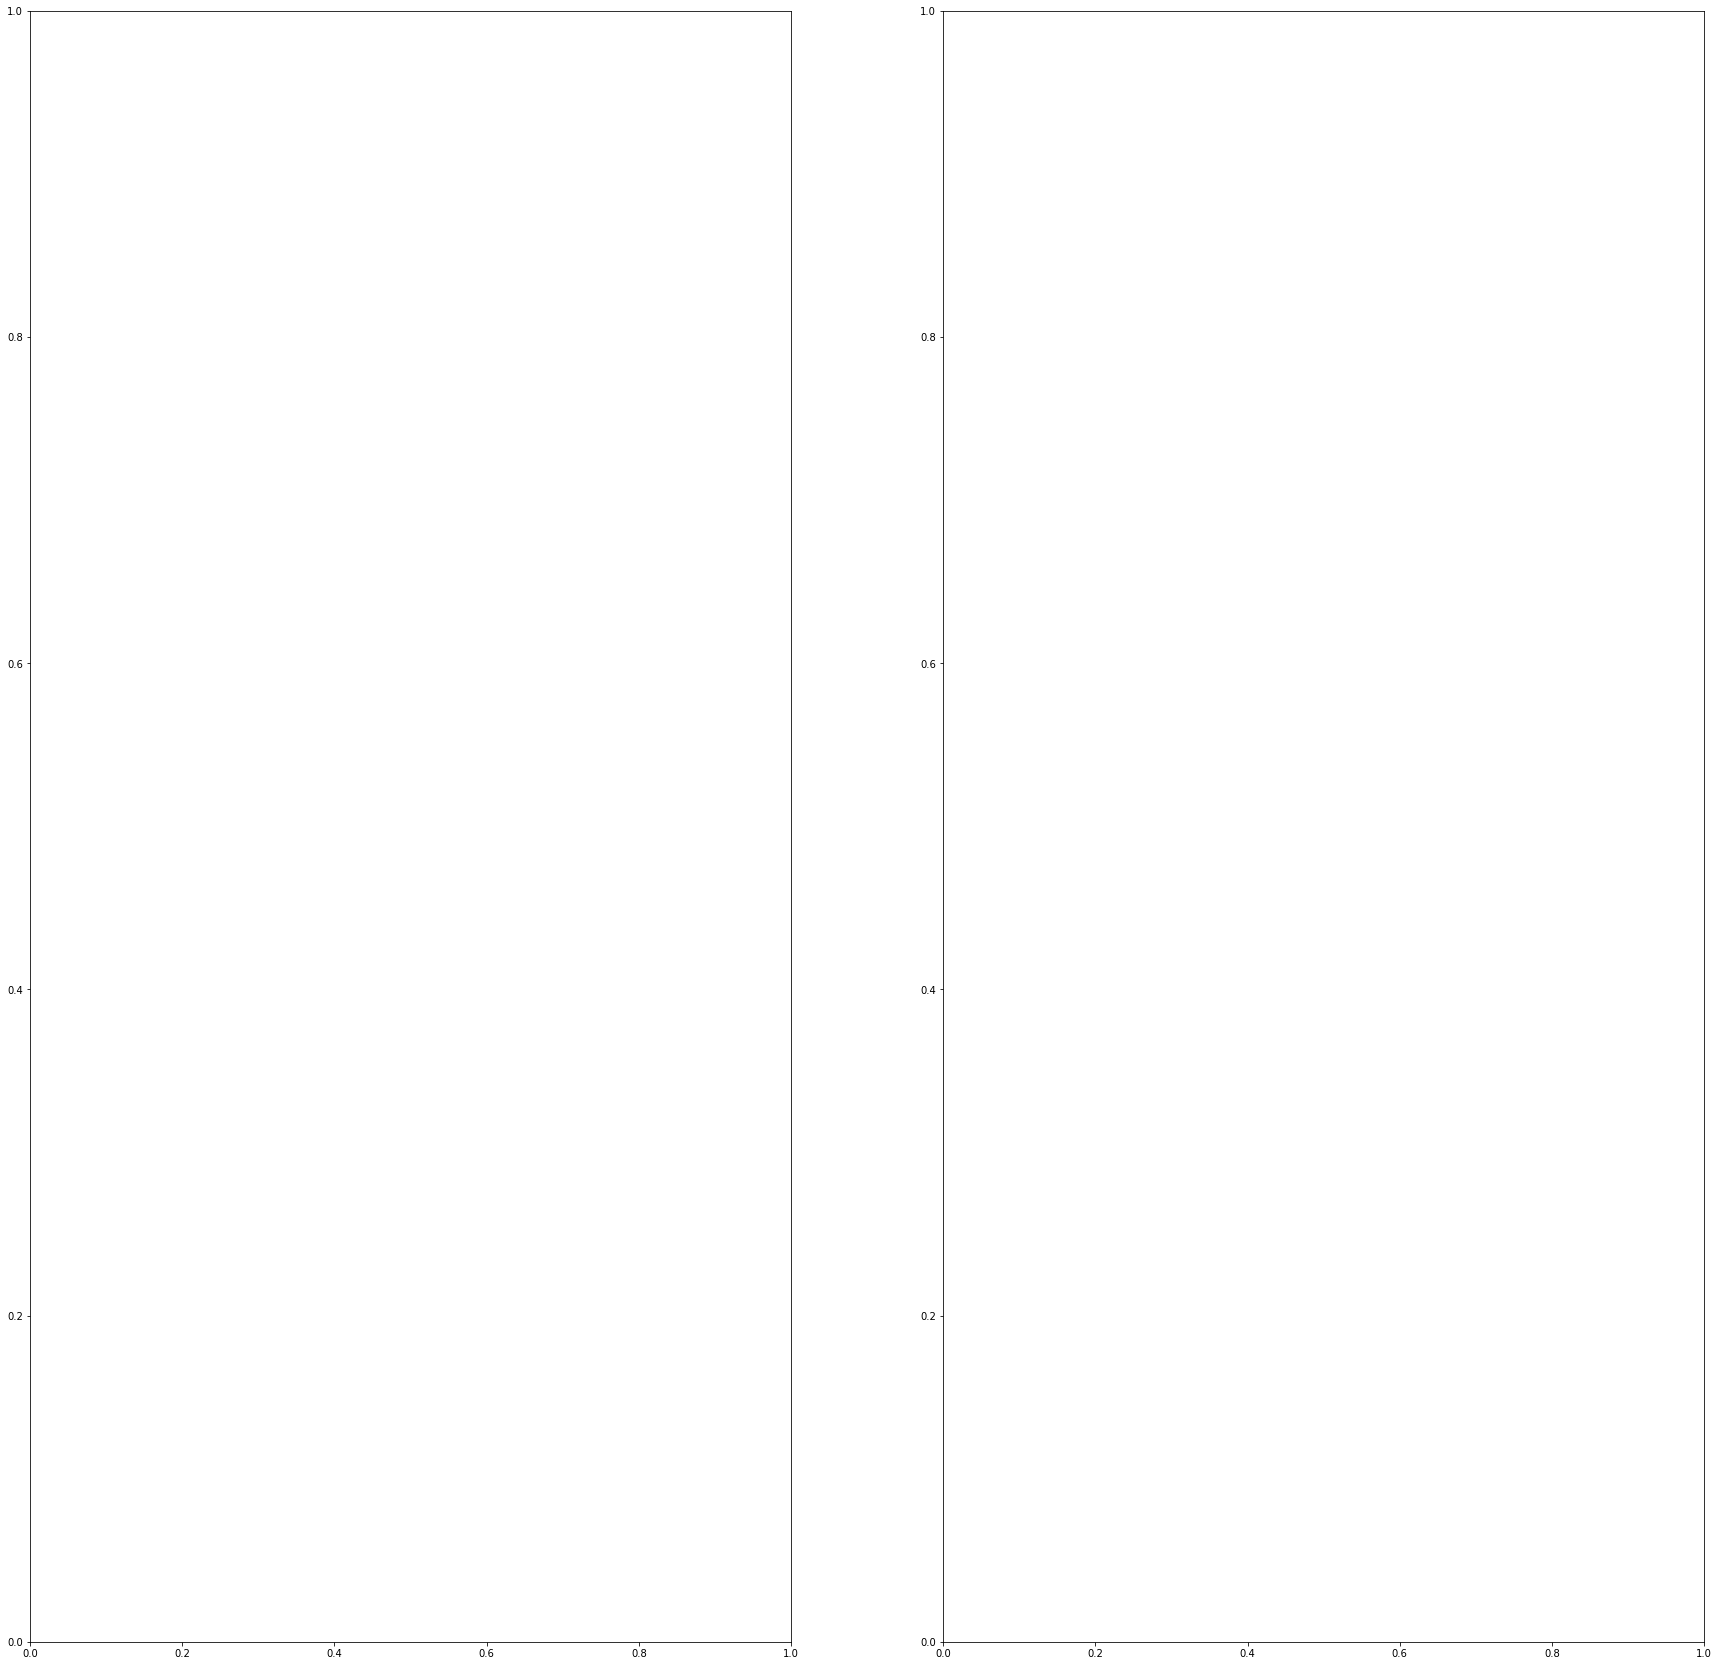

In [20]:
#plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].long_description,
#                     bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].long_description,
#                    'Description', False)
#plt.savefig(f"figures/rq3-all-long_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


### 9.3 Long Description Size

KeyError: 'long_description_words'

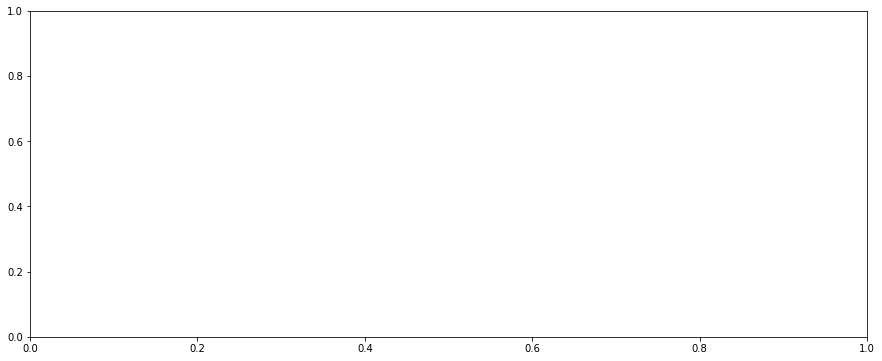

In [21]:
fig, ax   = plt.subplots(figsize=(15, 6))
threshold = 350
df   = bug_reports_all_data.loc[(bug_reports_all_data["long_description_words"] < threshold)] 
eclipse   = df.loc[(df["project"]=="eclipse")]["long_description_words"] 
sns.distplot(eclipse, hist=False, label="eclipse")
freedesktop = df.loc[(df["project"]=="freedesktop")]["long_description_words"] 
sns.distplot(freedesktop, hist=False, label="freedesktop")
gcc = df.loc[(df["project"]=="gcc")]["long_description_words"] 
sns.distplot(gcc, hist=False, label="gcc")
gnome = df.loc[(df["project"]=="gnome")]["long_description_words"] 
sns.distplot(gnome, hist=False, label="gnome")
mozilla = df.loc[(df["project"]=="mozilla")]["long_description_words"] 
sns.distplot(mozilla, hist=False, label="mozilla")
winehq = df.loc[(df["project"]=="winehq")]["long_description_words"] 
sns.distplot(winehq, hist=False, label="winehq")

KeyError: 'long_description_words'

<Figure size 432x288 with 0 Axes>

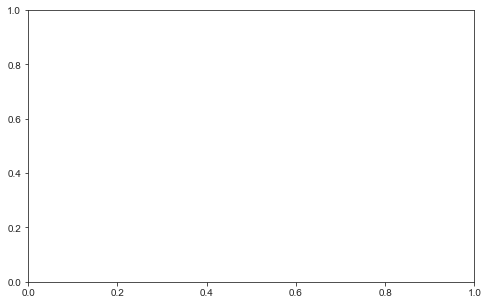

In [22]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
sns.despine(offset=10)
sns.set_style("ticks")
threshold = 150

fig, ax = plt.subplots(figsize=(8, 5))
df = bug_reports_all_data.loc[(bug_reports_all_data["long_description_words"] < threshold)] 
g  = sns.boxplot(data=df, x="long_description_words", y="project", palette="Set2", ax=ax, showfliers = False, flierprops = dict(markerfacecolor = '.10', markersize = 2))
plt.ylabel("", fontsize= 12)
plt.xlabel("Number of Words per Bug Report (in Description)", fontsize= 12)
plt.title("", fontsize= 15)
ax.yaxis.grid(True)
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set(xlim=(0, threshold))
sns.despine(trim=True, left=True)
plt.savefig(f"figures/rq2-bug-fix-time-distribution.pdf", format="pdf", dpi=600, bbox_inches='tight')

#sns.despine(offset=10)
#fig, ax = plt.subplots(figsize=(15, 6))
#threshold = 350
#df   = bug_reports_all_data.loc[(bug_reports_all_data["long_description_words"] < threshold)] 
#g = sns.boxplot(data=df, x="long_description_words", y="project"
#                , palette="Set2", ax=ax, flierprops = dict(markerfacecolor = '.10', markersize = 2))
#

In [23]:
from numpy import percentile
for project in projects:
    display(project)
    bug_reports_data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    display(bug_reports_data['long_description_words'].describe())
    q25, q75 = percentile(bug_reports_data['long_description_words'], 25), percentile(bug_reports_data['long_description_words'], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    outliers =  [x for x in bug_reports_data['long_description_words'] if x < lower or x > upper]
    # identify outliers
    outliers = [x for x in bug_reports_data['long_description_words'] if x < lower or x > upper]
    print('Identified outliers: %.3f' % (len(outliers)/len(bug_reports_data)*100))

'eclipse'

KeyError: 'long_description_words'

### 9.4 Bug Reports File Size Distribution

KeyError: 'file_size'

<Figure size 432x288 with 0 Axes>

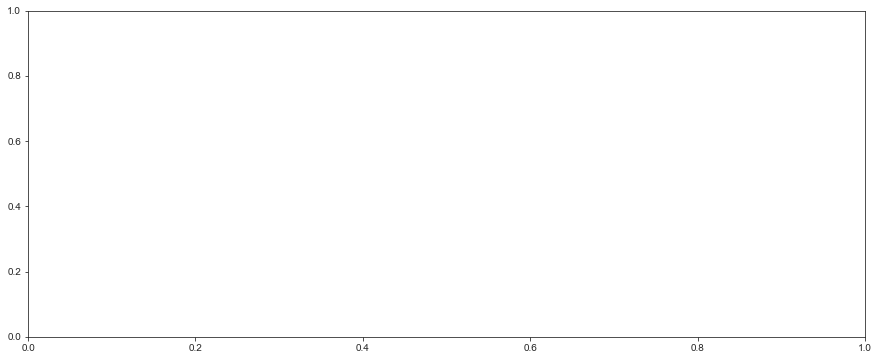

In [24]:
sns.despine(offset=10)
fig, ax = plt.subplots(figsize=(15, 6))
threshold = 1
df   = bug_reports_all_data.loc[(bug_reports_all_data["file_size"] < threshold)] 
g = sns.boxplot(data=df, x="file_size", y="project"
                , palette="Set2", ax=ax, flierprops = dict(markerfacecolor = '.10', markersize = 2))

## Step 10. Analysis of Severity Level

### Severity level distribution

long_lived? severity_category  long-lived  short-lived
0                     blocker    0.014778     0.985222
1                    critical    0.027855     0.972145
2                       major    0.076110     0.923890
3                       minor    0.117021     0.882979
4                      normal    0.072879     0.927121
5                     trivial    0.108974     0.891026
long_lived? severity_category  long-lived  short-lived
0                     blocker    0.034221     0.965779
1                    critical    0.095550     0.904450
2                       major    0.121481     0.878519
3                       minor    0.223952     0.776048
4                      normal    0.147488     0.852512
5                     trivial    0.170569     0.829431
long_lived? severity_category  long-lived  short-lived
0                     blocker    0.043103     0.956897
1                    critical    0.104575     0.895425
2                       major    0.157124     0.842876
3         

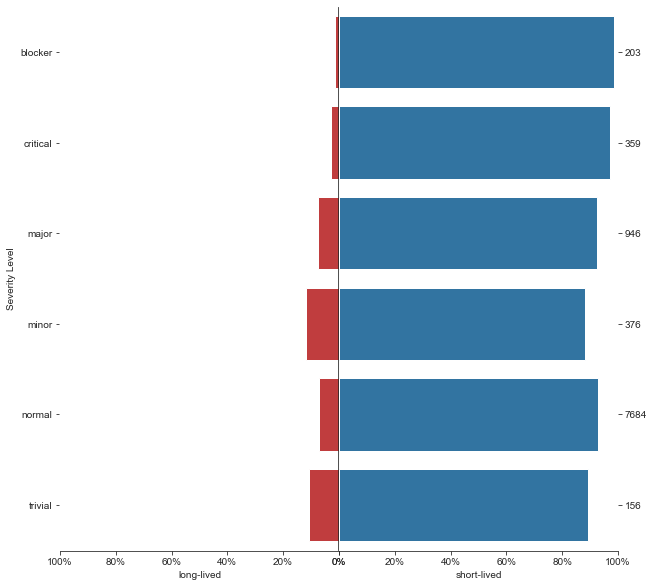

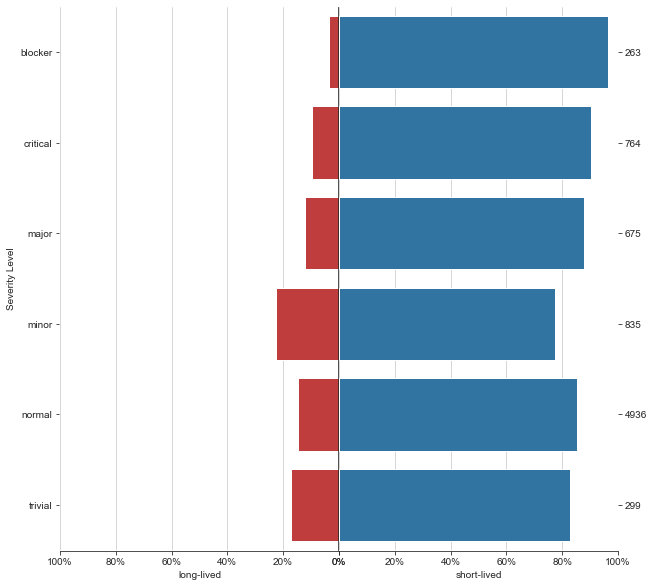

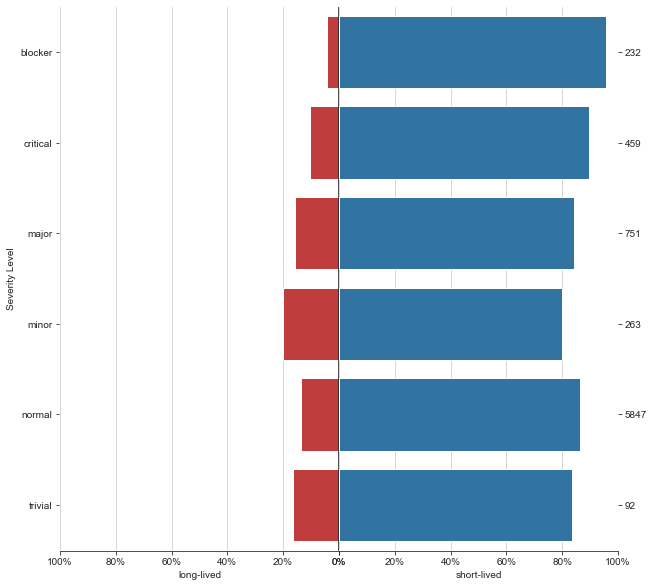

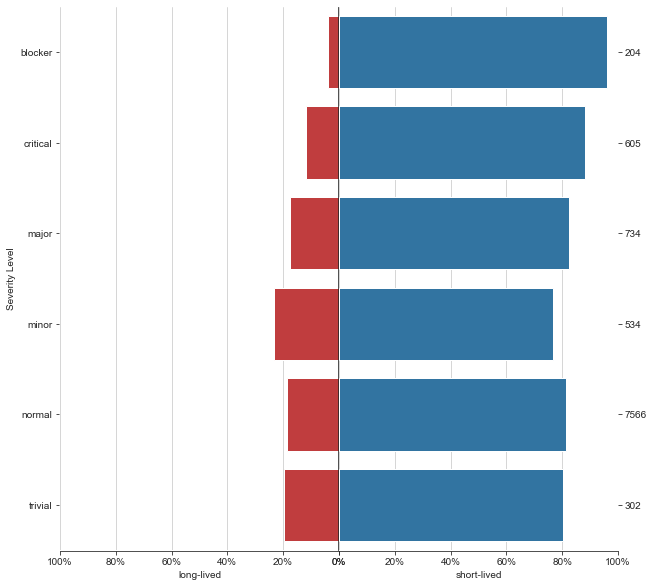

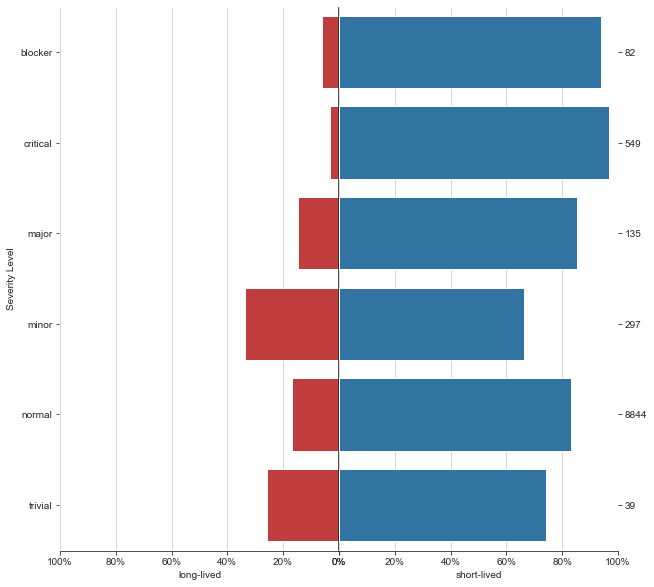

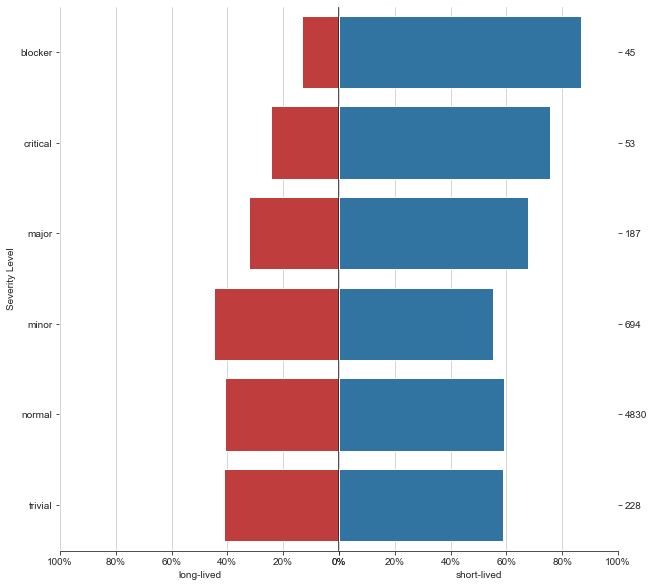

In [32]:
for project in projects:
    bug_reports_all_data_by_project = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    filename = f"rq3-{project}-ll-sl-severity_level.pdf"
    plot_pyramid (bug_reports_all_data_by_project, 'severity_category', 'severity_category', filename)
